In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler

In [116]:
train = pd.read_csv("./data/washing_data.csv")
pd.set_option('display.max_columns', None)
print(train.shape)

(7284, 39)


特征转换

In [117]:
# 新建一个csv文件保存处理后的数据
train.to_csv('./data/Wimbledon_washed_features.csv', index=False)

train.head(10)

,p1_sets,p2_sets,sub_set,game_no,p1_games,p2_games,sub_game,p1_score,p2_score,server,serve_no,point_victor,p1_points_won,p2_points_won,sub_point,game_victor,p1_ace,p2_ace,p1_winner,p2_winner,winner_shot_type,p1_double_fault,p2_double_fault,p1_unf_err,p2_unf_err,p1_net_pt,p2_net_pt,p1_net_pt_won,p2_net_pt_won,p1_break_pt,p2_break_pt,p1_break_pt_won,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,player1_quality,player2_quality,elo1,elo2
0,0,0,0,1,0,0,0,0,0,1,2,2,0,1,-1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2.95,1.3,1781.335773,1136.779506
1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.95,1.3,1742.291141,1175.824138
2,0,0,0,1,0,0,0,1,1,1,1,2,1,2,-1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2.95,1.3,1743.768705,1174.346574
3,0,0,0,1,0,0,0,1,2,1,1,1,2,2,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2.95,1.3,1705.222252,1212.893027
4,0,0,0,1,0,0,0,2,2,1,1,1,3,2,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.95,1.3,1707.442667,1210.672612
5,0,0,0,1,0,0,0,3,2,1,2,2,3,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.95,1.3,1709.610076,1208.505203
6,0,0,0,1,0,0,0,3,3,1,1,1,4,3,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.95,1.3,1671.726898,1246.388382
7,0,0,0,1,0,0,0,4,3,1,2,2,4,4,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,2.95,1.3,1674.908990,1243.206289
8,0,0,0,1,0,0,0,3,3,1,1,1,5,4,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,2.95,1.3,1637.985419,1280.129860
9,0,0,0,1,0,0,0,4,3,1,1,1,6,4,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.95,1.3,1642.507324,1275.607955


特征增强

In [118]:
train = pd.read_csv('./data/Wimbledon_washed_features.csv')

# 对比较重要的特征进行非线性变换，特征增强
train['sub_point_squared'] = train['sub_point'] ** 2
train['serve_no_squared'] = train['serve_no'] ** 2
train['elo1_squared'] = train['elo1'] ** 2
train['elo2_squared'] = train['elo2'] ** 2
train['player1_quality_squared'] = train['player1_quality'] ** 2
train['player2_quality_squared'] = train['player2_quality'] ** 2

train['elo1'], train['elo2'] = train['elo1'] / (train['elo1'] + train['elo2']), train['elo2'] / (train['elo1'] + train['elo2'])
train['player1_quality'], train['player2_quality'] = train['player1_quality'] / (train['player1_quality'] + train['player2_quality']), train['player2_quality'] / (train['player1_quality'] + train['player2_quality'])
train['elo1_squared'], train['elo2_squared'] = train['elo1_squared'] / (train['elo1_squared'] + train['elo2_squared']), train['elo2_squared'] / (train['elo1_squared'] + train['elo2_squared'])
train['player1_quality_squared'], train['player2_quality_squared'] = train['player1_quality_squared'] / (train['player1_quality_squared'] + train['player2_quality_squared']), train['player2_quality_squared'] / (train['player1_quality_squared'] + train['player2_quality_squared'])

# 保存处理后的数据
train.to_csv('./data/gru_input.csv', index=False)

特征分析

In [119]:
train_X = train.drop(['game_victor'], axis=1)
train_Y = train['game_victor']
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7284 entries, 0 to 7283
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   p1_sets                  7284 non-null   int64  
 1   p2_sets                  7284 non-null   int64  
 2   sub_set                  7284 non-null   int64  
 3   game_no                  7284 non-null   int64  
 4   p1_games                 7284 non-null   int64  
 5   p2_games                 7284 non-null   int64  
 6   sub_game                 7284 non-null   int64  
 7   p1_score                 7284 non-null   int64  
 8   p2_score                 7284 non-null   int64  
 9   server                   7284 non-null   int64  
 10  serve_no                 7284 non-null   int64  
 11  point_victor             7284 non-null   int64  
 12  p1_points_won            7284 non-null   int64  
 13  p2_points_won            7284 non-null   int64  
 14  sub_point               

In [107]:
""" from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=[0.1, 0.01, 0.001], cv=5)
lasso_cv.fit(train_X, train_Y)

print("Best alpha: ", lasso_cv.alpha_) """

lasso = Lasso(alpha=0.0005)
lasso.fit(train_X, train_Y)

Lasso(alpha=0.0005)

In [108]:
FI_lasso = pd.DataFrame({"Feature Importance": lasso.coef_}, index=train_X.columns)

In [109]:
FI_lasso.sort_values("Feature Importance", ascending=False)  # 利用Lasso计算出特征重要性

,Feature Importance
server,0.425168
p2_break_pt_won,0.348900
p2_break_pt,0.250581
point_victor,0.224307
sub_set,0.027463
p2_ace,0.006767
sub_game,0.003724
p2_winner,0.002668
p1_unf_err,0.002234
game_no,0.001929


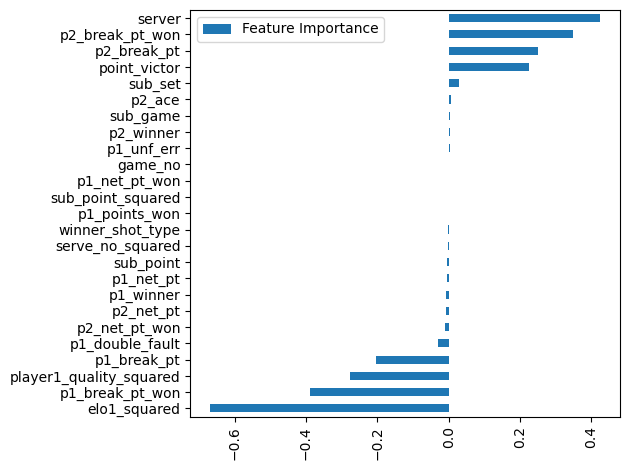

In [110]:
FI_lasso[FI_lasso["Feature Importance"] != 0].sort_values("Feature Importance").plot(kind="barh")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('./image/lasso_feature_importance.png', bbox_inches='tight')
plt.show()

In [120]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)

# 过采样
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_sm, y_sm)

y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 分析特征重要性
feature_importances = pd.Series(rf.feature_importances_, index=train_X.columns).sort_values(ascending=False)
print(feature_importances)

Accuracy: 0.8922443376801648
              precision    recall  f1-score   support

           1       0.92      0.86      0.89       733
           2       0.87      0.92      0.89       724

    accuracy                           0.89      1457
   macro avg       0.89      0.89      0.89      1457
weighted avg       0.89      0.89      0.89      1457

server                     0.113656
player1_quality_squared    0.106917
player2_quality_squared    0.096218
player1_quality            0.087755
player2_quality            0.082865
point_victor               0.059550
p1_points_won              0.029785
p2_points_won              0.029391
elo1                       0.029054
elo2_squared               0.027967
elo2                       0.027648
p1_score                   0.026903
elo1_squared               0.026622
sub_point                  0.025718
p2_score                   0.023366
sub_point_squared          0.022028
game_no                    0.021323
p1_games                   0.017

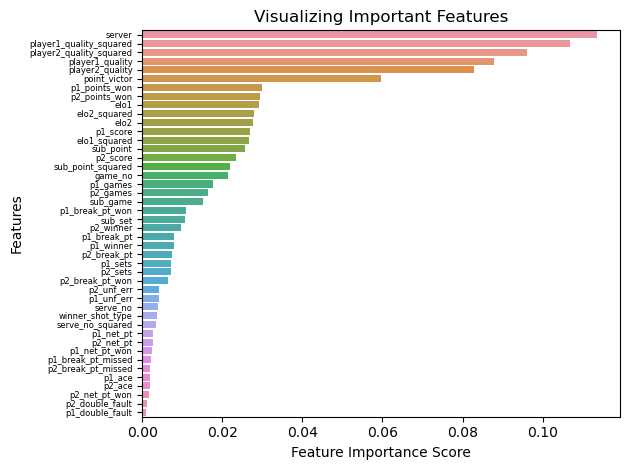

In [121]:
# 可视化
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.yticks(fontsize=6)
plt.title("Visualizing Important Features")

plt.tight_layout()
plt.savefig('./image/feature_importance.png')
plt.show()